<a href="https://colab.research.google.com/github/sedaoturak/tricks_for_efficient_pytorch/blob/main/efficient_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Useful tips for more efficient Pytorch codes**

This list of tips was prepared by using the resources below:
1. https://nvlabs.github.io/eccv2020-mixed-precision-tutorial/files/szymon_migacz-pytorch-performance-tuning-guide.pdf
2. https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html 
3. https://efficientdl.com/faster-deep-learning-in-pytorch-a-guide/
4. https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b

# Model
An example model to show the tips (VAE with CNN)

*Model was taken from the website given below:*

https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [22]:
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
    val_loss = running_loss / counter
    return val_loss

In [23]:
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='mean')
# criterion = nn.BCELoss(reduction='sum')
# criterion = nn.BCEWithLogitsLoss(reduction='sum')

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(root='../input', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(root='../input', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

In [ ]:
train_loss = []
valid_loss = []
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print('Epoch: {:03d}, Train: {:.4e}, Test: {:.4e}'.format(epoch+1,train_epoch_loss,valid_epoch_loss))
    # if (epoch+1) % 20 == 0:
    #     print('Epoch: {:03d}, Train: {:.4e}, Test: {:.4e}'.format(epoch+1,train_epoch_loss,valid_epoch_loss))

# 1.DataLoader Attributes

1.1. set `num_workers > 0`

Rule of thumb: it is two times number of available GPU, otherwise it leads it to slow down!

`num_workers = 4 * num_GPU`

1.2. set `pin_memory=True`

It must be `True` together with `num_workers > 0`, otherwise it won't affect the speed.

recommended resource: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

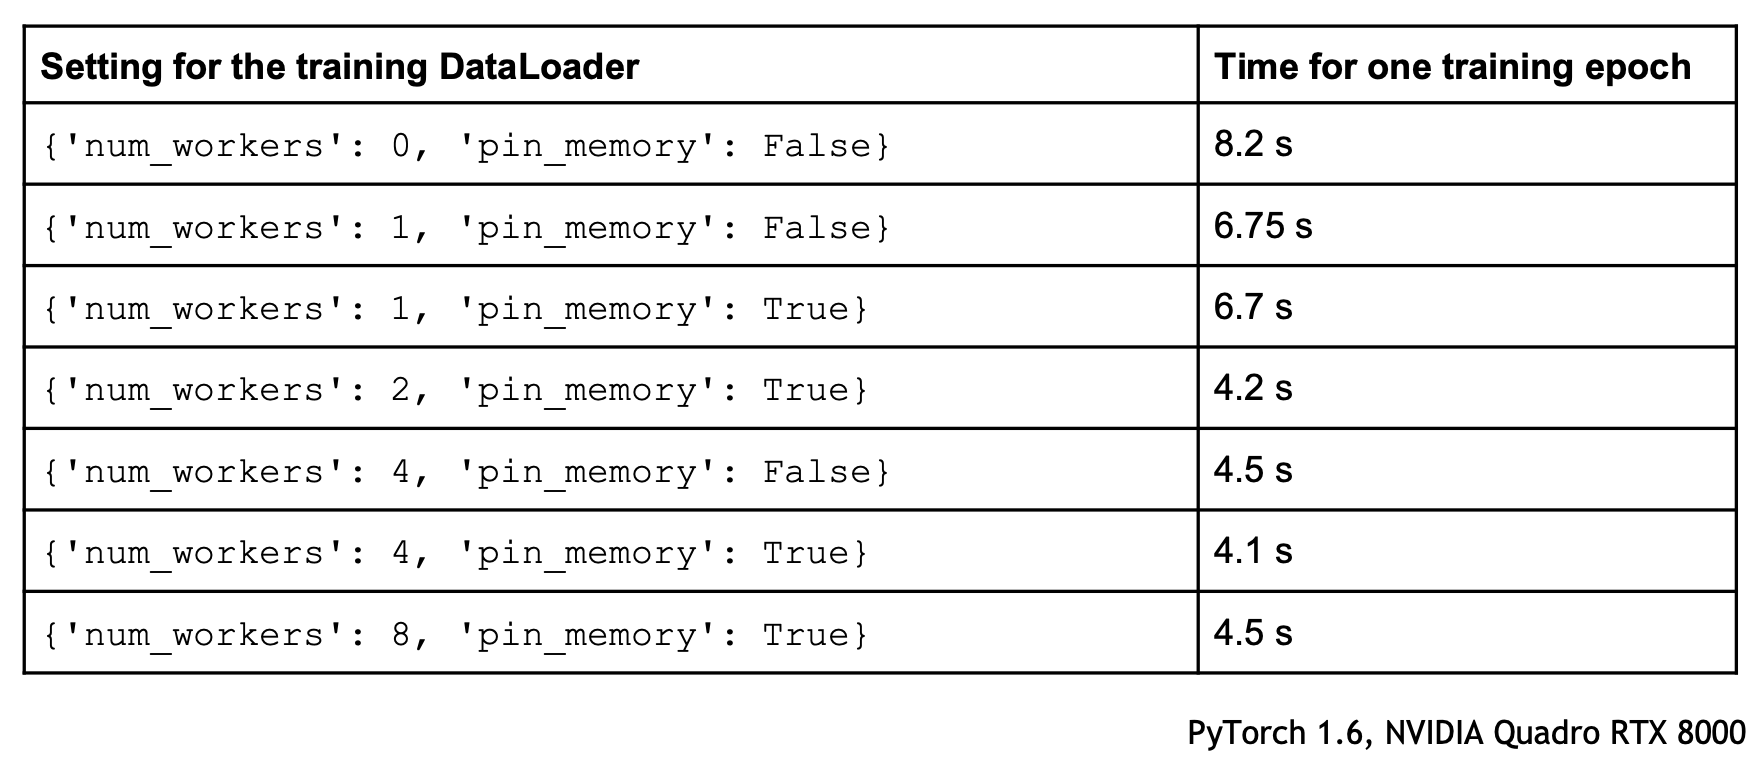

# 2.Balance Learning Rate and Batch Size

Double the learning rate when you double the batch size.

In [ ]:
import time
start_time = time.time()

# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

# training set and train data loader
trainset = torchvision.datasets.MNIST(root='../input', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(root='../input', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

train_loss = []
valid_loss = []
epochs = 101
for epoch in range(epochs):
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    if (epoch+1) % 20 == 0:
        print('Epoch: {:03d}, Train: {:.4e}, Test: {:.4e}'.format(epoch+1,train_epoch_loss,valid_epoch_loss))

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch: 020, Train: 9.6879e+03, Test: 9.6311e+03
Epoch: 040, Train: 9.5517e+03, Test: 9.5294e+03
Epoch: 060, Train: 9.4986e+03, Test: 9.5144e+03
Epoch: 080, Train: 9.4642e+03, Test: 9.4741e+03
Epoch: 100, Train: 9.4429e+03, Test: 9.4859e+03
Total time: 1541.712s


In [ ]:
import time
start_time = time.time()

# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.002
batch_size = 128
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

# training set and train data loader
trainset = torchvision.datasets.MNIST(root='../input', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(root='../input', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

train_loss = []
valid_loss = []
epochs = 101
for epoch in range(epochs):
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    if (epoch+1) % 20 == 0:
        print('Epoch: {:03d}, Train: {:.4e}, Test: {:.4e}'.format(epoch+1,train_epoch_loss,valid_epoch_loss))

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch: 020, Train: 1.9638e+04, Test: 1.9543e+04
Epoch: 040, Train: 1.9403e+04, Test: 1.9278e+04
Epoch: 060, Train: 1.9291e+04, Test: 1.9183e+04
Epoch: 080, Train: 1.9215e+04, Test: 1.9150e+04
Epoch: 100, Train: 1.9170e+04, Test: 1.9167e+04
Total time: 1210.743s


In [ ]:
import time
start_time = time.time()

# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
batch_size = 128
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

# training set and train data loader
trainset = torchvision.datasets.MNIST(root='../input', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(root='../input', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False)

train_loss = []
valid_loss = []
epochs = 101
for epoch in range(epochs):
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    if (epoch+1) % 20 == 0:
        print('Epoch: {:03d}, Train: {:.4e}, Test: {:.4e}'.format(epoch+1,train_epoch_loss,valid_epoch_loss))

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch: 020, Train: 1.9624e+04, Test: 1.9381e+04
Epoch: 040, Train: 1.8992e+04, Test: 1.8822e+04
Epoch: 060, Train: 1.8827e+04, Test: 1.8738e+04
Epoch: 080, Train: 1.8744e+04, Test: 1.8629e+04
Epoch: 100, Train: 1.8691e+04, Test: 1.8572e+04
Total time: 1209.328s


# 3.Use Automatic Mixed Precision (AMP)

Deep learning frameworks in PyTorch uses 32-bit floating point (FP32) while doing the calculations for the optimization of the neural network's weights, biases and hyperparameters during the trainng. However, using 16-bit floating point enables certain efficiencies in terms of computation time and lower memmory usage while giving the same results in the case of using FP32. AMP method determines which floating point is optimum for each calculations. 

recommended resource: https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/

In [17]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
          reconstruction, mu, logvar = model(data)
          bce_loss = criterion(reconstruction, data)
          loss = final_loss(bce_loss, mu, logvar)

        # loss.backward()
        # Scales the loss, and calls backward() to create scaled gradients
        scaler.scale(loss).backward()
        
        # optimizer.step()
        # Unscales gradients and calls
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()

        running_loss += loss.item()
        train_loss = running_loss / counter 
    return train_loss

In [21]:
import time
start_time = time.time()

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

train_loss = []
valid_loss = []
epochs = 101
for epoch in range(epochs):
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    if (epoch+1) % 20 == 0:
        print('Epoch: {:03d}, Train: {:.4e}, Test: {:.4e}'.format(epoch+1,train_epoch_loss,valid_epoch_loss))

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch: 020, Train: 5.6523e-02, Test: 5.6837e-02
Epoch: 040, Train: 5.6492e-02, Test: 5.6844e-02
Epoch: 060, Train: 5.6488e-02, Test: 5.6819e-02
Epoch: 080, Train: 5.6482e-02, Test: 5.6825e-02
Epoch: 100, Train: 5.6479e-02, Test: 5.6854e-02
Total time: 1620.122s


In [25]:
import time
start_time = time.time()

train_loss = []
valid_loss = []
epochs = 101
for epoch in range(epochs):
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    if (epoch+1) % 20 == 0:
        print('Epoch: {:03d}, Train: {:.4e}, Test: {:.4e}'.format(epoch+1,train_epoch_loss,valid_epoch_loss))

print('Total time: {:.3f}s'.format(time.time() - start_time))

Epoch: 020, Train: 5.6522e-02, Test: 5.6859e-02
Epoch: 040, Train: 5.6492e-02, Test: 5.6860e-02
Epoch: 060, Train: 5.6483e-02, Test: 5.6810e-02
Epoch: 080, Train: 5.6482e-02, Test: 5.6827e-02


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd82169dc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd82169dc10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in: <function _MultiProce

Epoch: 100, Train: 5.6477e-02, Test: 5.6828e-02
Total time: 1598.126s


# 4.Turn on cudNN Benchmarking

set `torch.backends.cudnn.benchmark = True`

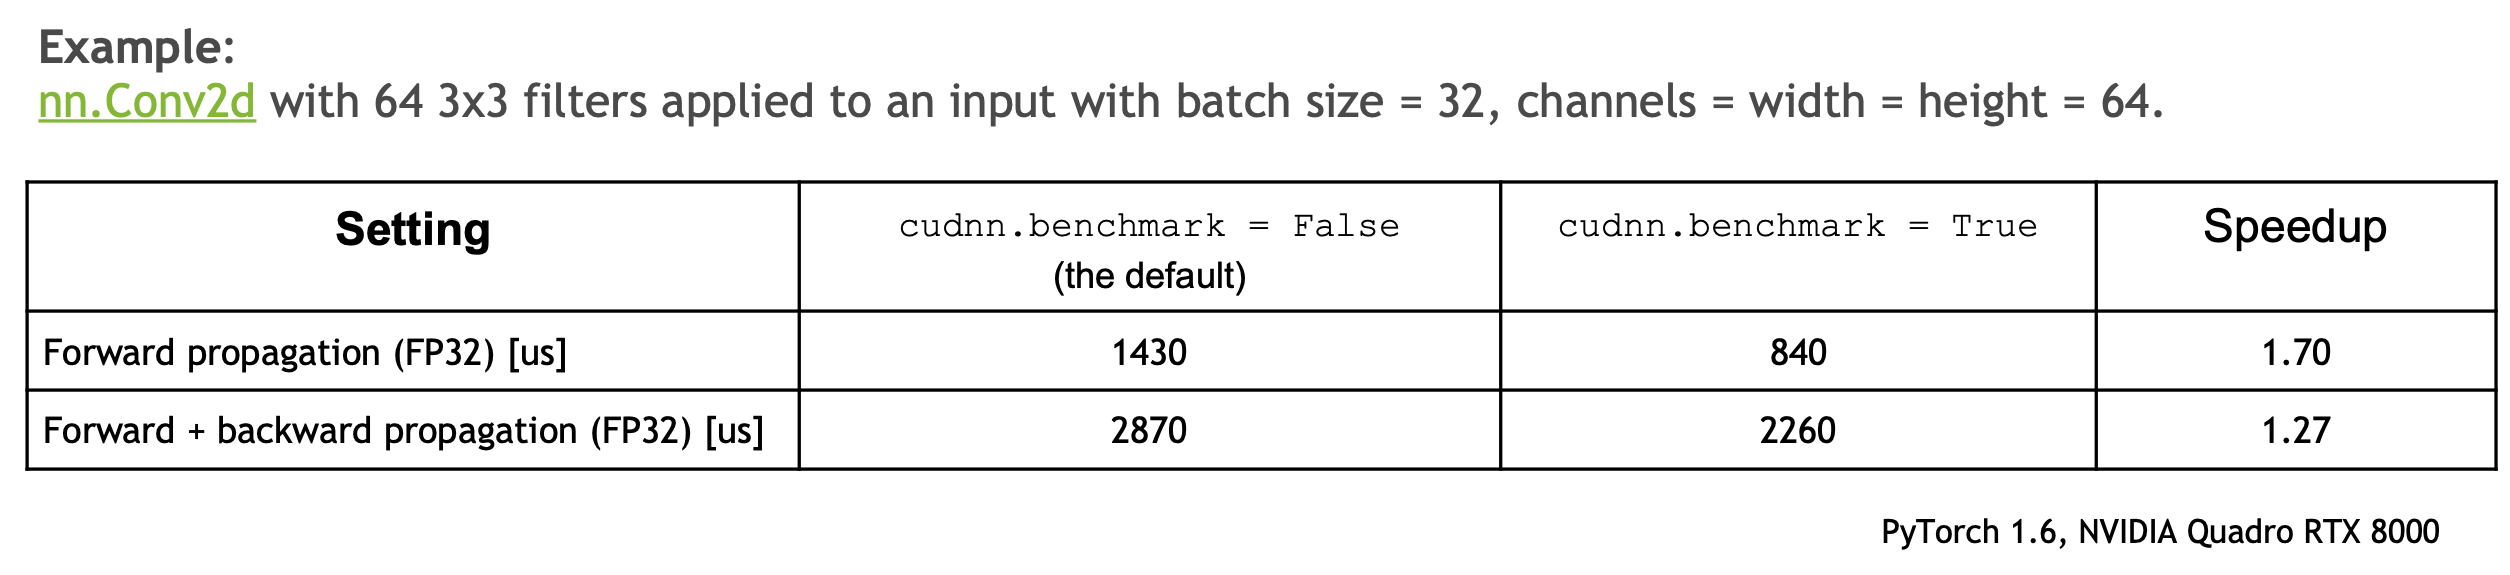

# 5.Create New Tensors on GPU

`t = tensor.rand(2,2, device=torch.device('cuda:0'))` instead of `t = tensor.rand(2,2).cuda()`. The latter will generate the tensor on CPU first and then transfer it to GPU, which takes time.

In [ ]:
start_time = time.time()

for _ in range(100):
  # Creating on the CPU, then transfering to the GPU
  cpu_tensor = torch.ones((1000, 64, 64))
  gpu_tensor = cpu_tensor.cuda()

print('Total time: {:.3f}s'.format(time.time() - start_time))

Total time: 4.784s


In [ ]:
start_time = time.time()

for _ in range(100):
  # Creating on GPU directly
  cpu_tensor = torch.ones((1000, 64, 64), device='cuda')

print('Total time: {:.3f}s'.format(time.time() - start_time))

Total time: 0.009s


# 6.Avoid Tensor Transfer between CPU and GPU


```
# bad
.cpu()
.item()
.numpy()

# good
.detach()
```



# 7.Use Gradient/Activation Checkpointing

It decreases the computation time by saving computations as functions instead of intermediate values. It also decreases memory fingerprint.

recommended resources: https://qywu.github.io/2019/05/22/explore-gradient-checkpointing.html
https://github.com/prigoyal/pytorch_memonger/blob/master/tutorial/Checkpointing_for_PyTorch_models.ipynb

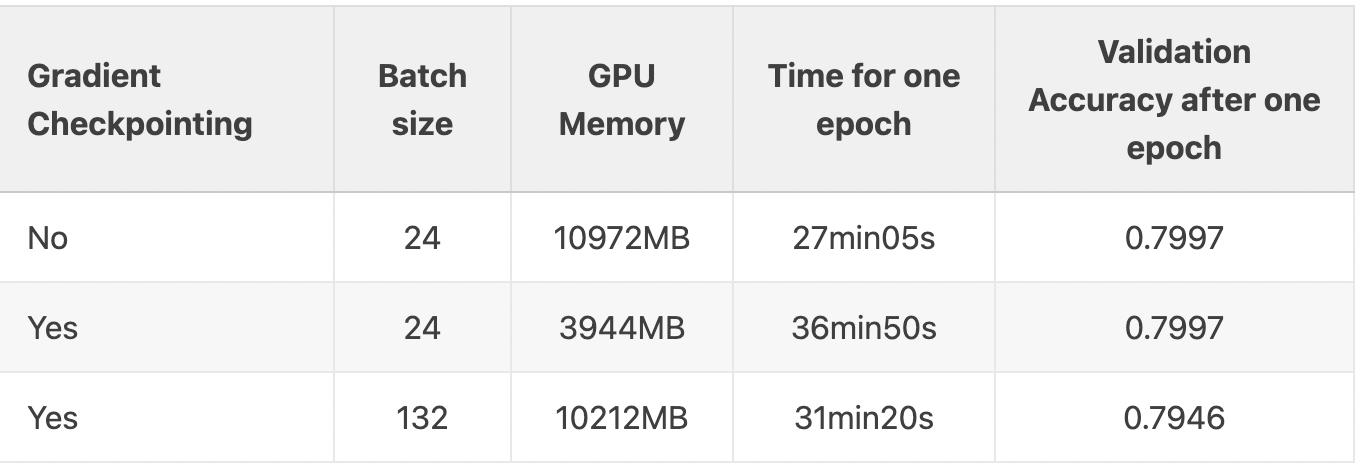

# 8.Set Gradients to None Rather Than Zero

Use 
```
for param in model.parameters():
    param.grad = None
``` or
`.zero_grad(set_to_none=True)` rather than `.zero_grad()`



recommended resource: https://github.com/prigoyal/pytorch_memonger/blob/master/tutorial/Checkpointing_for_PyTorch_models.ipynb

# 9.Use `.as_tensor()` rather than `.tensor()`

"`torch.tensor()` always copies the data whereas `torch.as_tensor()` always tries to avoid copies of the data. This is especially useful if you have a numpy array and want to avoid copying the numpy array into a tensor."

recommended resource: https://upendrak.github.io/posts/2020/0-GAN/tensor-functions-pytorch/

# 10.Turn off Bias Before BatchNorm

set the bias keyword to False: `torch.nn.Conv2d(..., bias=False, ...)`

`Batch normalization = gamma * normalize(x) + bias`. So, even if you implement the ConvWithBias+BatchNorm, it will behave like ConvWithoutBias+BatchNorm. It is the same as multiple fully-connected layers without activation function will behave like a single one.

recommended resource: https://stackoverflow.com/questions/46256747/can-not-use-both-bias-and-batch-normalization-in-convolution-layers

# 11.Turn off Gradient Computation During Validation

set `torch.no_grad()` during validation

In [ ]:
# in the validation loop:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad(): # for validation loop only
        for i, data in enumerate(dataloader):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
    val_loss = running_loss / counter
    return val_loss

# 12.Use JIT to Fuse Point-wise Operations

If there is an mathematical operation on images or other tensors used in the model, use the decorator `@torch.jit.script`. By this way, calculations will be done on only one kernel, rather than multiple kernels by default.

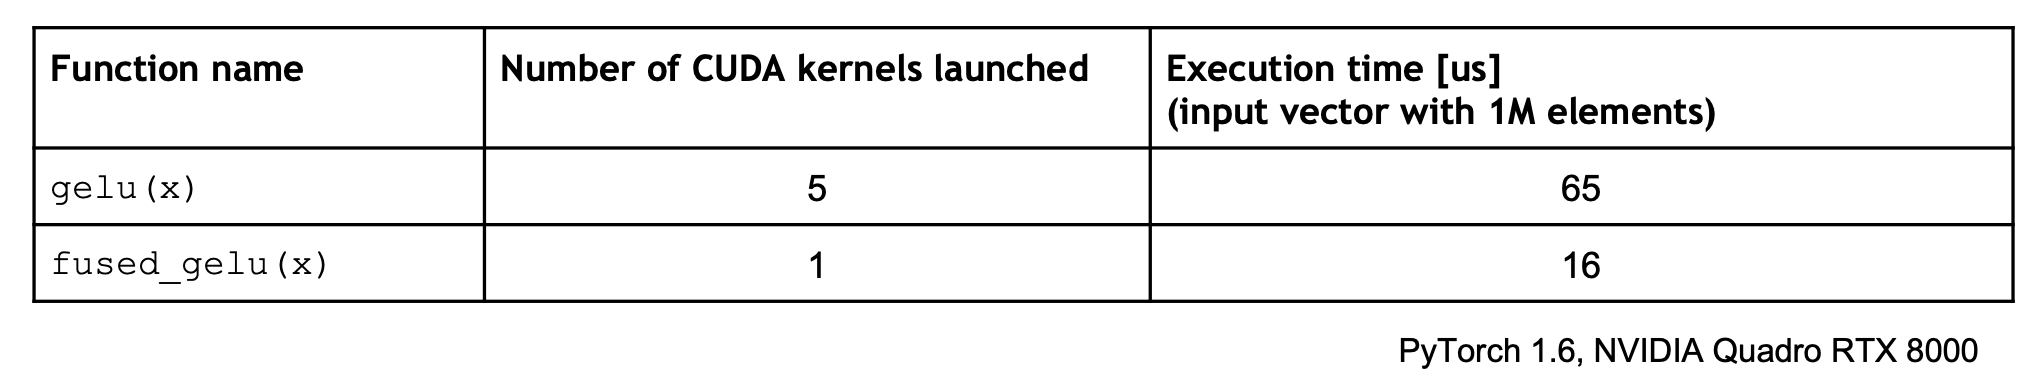

In [ ]:
# example code snipet for fuse point-wise operation definition
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))

@torch.jit.script
def fused_gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))

# 13.Disable Debug APIs for Final Training

run following codes after debugging the model:
```
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
```

